In [ ]:
# 필요한 패키지 설치
!pip install --quiet transformers
!pip install --quiet torch torchvision torchaudio
!pip install --quiet pandas matplotlib seaborn
!pip install --quiet scikit-learn
!pip install --quiet scipy
# !pip install --quiet prophet
!pip install --quiet konlpy
!pip install --quiet nltk

In [1]:
import pandas as pd

# 기사 데이터 로드
articles = pd.read_csv("articles.csv", dtype=str).dropna()

# 기사 ID 추출
def extract_article_id(url):
    try:
        return url.split("/article/")[1].split("?")[0]
    except:
        return None

articles["article_id"] = articles["url"].apply(extract_article_id)
articles = articles.drop_duplicates(subset="article_id")

# 댓글 데이터 로드
comments = pd.read_csv("comments.csv", dtype=str).dropna()

# section_code 컬럼 제거
if "section_code" in comments.columns:
    comments = comments.drop(columns=["section_code"])

# 타입 변환
comments["recommend_count"] = comments["recommend_count"].astype(int)
comments["unrecommend_count"] = comments["unrecommend_count"].astype(int)
comments["comment_date"] = pd.to_datetime(comments["comment_date"], errors="coerce")
articles["pub_datetime"] = pd.to_datetime(articles["pub_datetime"], errors="coerce")

# 데이터 병합
merged = pd.merge(comments, articles, on="article_id", how="inner")
merged.dropna(subset=["comment_date", "pub_datetime"], inplace=True)

# 날짜 파생 컬럼 생성
merged["comment_day"] = merged["comment_date"].dt.date
merged["comment_week"] = merged["comment_date"].dt.to_period("W").apply(lambda r: r.start_time.date())
merged["comment_month"] = merged["comment_date"].dt.to_period("M").astype(str)

In [2]:
import re
from collections import Counter

# 불용어 리스트 정의
custom_stopwords = set([
    "있다", "하다", "되다", "그", "이", "저", "등", "및", "때문", "의", "를", "은", "는", "에", "가", "과", "로", "해서",
    "입니다", "제목", "관련", "오늘", "내일", "이번", "보도", "기자", "뉴스", "위해", "것", "말", "더", "속", "왜", "또", "중", "같은",
    "동영상", "속보", "단독", "종합", "보여", "동영상기사", "없어", "없다", "개"
])

# 텍스트 정제 함수
def clean_text(text):
    text = re.sub(r"[^가-힣\s]", " ", str(text))
    text = re.sub(r"\s+", " ", text).strip()
    return text

# 날짜별 상위 키워드 추출
daily_keywords = {}
for day, group in merged.groupby("comment_day"):
    titles = group["title"].dropna().apply(clean_text)
    words = " ".join(titles).split()
    words = [w for w in words if w not in custom_stopwords and len(w) > 1]
    counter = Counter(words)
    daily_keywords[day] = counter.most_common(20)


# 예시 출력
for day, keywords in list(daily_keywords.items())[:3]:
    print(f"\n[{day}]")
    print(", ".join([f"{w}({c})" for w, c in keywords]))



[2024-12-01]
예산(546), 민주당(430), 철회(367), 대통령실(367), 이재명(330), 한동훈(325), 가상자산(302), 수출(300), 예산안(289), 추경호(266), 감액(256), 증액(225), 민주(221), 민생(218), 과세(218), 중단(217), 유예(213), 사과(209), 박찬대(204), 연속(192)

[2024-12-02]
예산안(413), 본회의(303), 검사(292), 한동훈(279), 탄핵(274), 이재명(268), 동덕여대(264), 여야(246), 보고(243), 대통령(232), 특활비(228), 감액(221), 검찰(214), 배달수수료(211), 상정(209), 감사원장(208), 수수료(207), 총학(204), 내년(202), 국회(197)

[2024-12-03]
비상계엄(721), 명태균(709), 선포(532), 대통령(521), 한동훈(467), 오세훈(310), 환율(273), 사망(261), 비상(247), 계엄(226), 국회(208), 선포에(195), 돌파(190), 윤석열(187), 부부(187), 긴급(177), 종북(172), 달러(171), 김건희(160), 세력(159)


In [43]:
# 섹션 코드만 지정해서 필터링
target_section = "100"  # 100: 정치, 101: 경제, 102: 사회 등

# 해당 섹션의 데이터만 추출
filtered_df = merged[merged["section_code"] == target_section]

# 결과 요약 출력
print(f"섹션 {target_section} 기사 수: {filtered_df['article_id'].nunique()}")
print(f"댓글 수: {len(filtered_df)}")

섹션 100 기사 수: 19986
댓글 수: 549610


In [44]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel

# 감정 레이블 매핑
label_map = {0: "분노", 1: "기대", 2: "기쁨", 3: "신뢰", 4: "공포", 5: "놀람", 6: "슬픔", 7: "혐오"}

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 클래스 정의
class PlutchikKcELECTRA(nn.Module):
    def __init__(self, model_name, num_labels=8, dropout_rate=0.3):
        super().__init__()
        self.electra = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.electra.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.electra(input_ids=input_ids, attention_mask=attention_mask)
        pooled = self.dropout(outputs.last_hidden_state[:, 0])
        return self.classifier(pooled)

# 모델과 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained("beomi/KcELECTRA-base")
model = PlutchikKcELECTRA("beomi/KcELECTRA-base")
model.load_state_dict(torch.load("best_plutchik_kcelectra.pt", map_location=device))
model.to(device)
model.eval()

<ipython-input-44-b5cd554f5a1d>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_plutchik_kcelectra.pt", map_location=device))


PlutchikKcELECTRA(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=3)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,)

In [45]:
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import numpy as np

# Dataset 정의
class CommentDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=64):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            str(self.texts[idx]),
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
        }

# 댓글 텍스트 리스트
texts = filtered_df["content"].tolist()

# 데이터셋과 로더 정의
dataset = CommentDataset(texts, tokenizer)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

# 감정 예측 실행
sigmoid = nn.Sigmoid()
all_preds, all_probs = [], []

for batch in tqdm(loader, desc="Predicting emotions"):
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
    probs = sigmoid(logits).cpu().numpy()
    for p in probs:
        pred = [label_map[i] for i, v in enumerate(p) if v >= 0.8]
        all_preds.append(pred or ["other"])
        all_probs.append(p.tolist())

# 결과 저장
filtered_df = filtered_df.copy()
filtered_df["pred_labels"] = all_preds
filtered_df["pred_probs"] = all_probs

Predicting emotions:   0%|          | 0/17176 [00:00<?, ?it/s]

Z-score anomalies: [datetime.date(2024, 11, 25), datetime.date(2025, 5, 12), datetime.date(2025, 5, 19)]
IForest anomalies: [datetime.date(2024, 11, 25), datetime.date(2025, 2, 3), datetime.date(2025, 5, 19)]


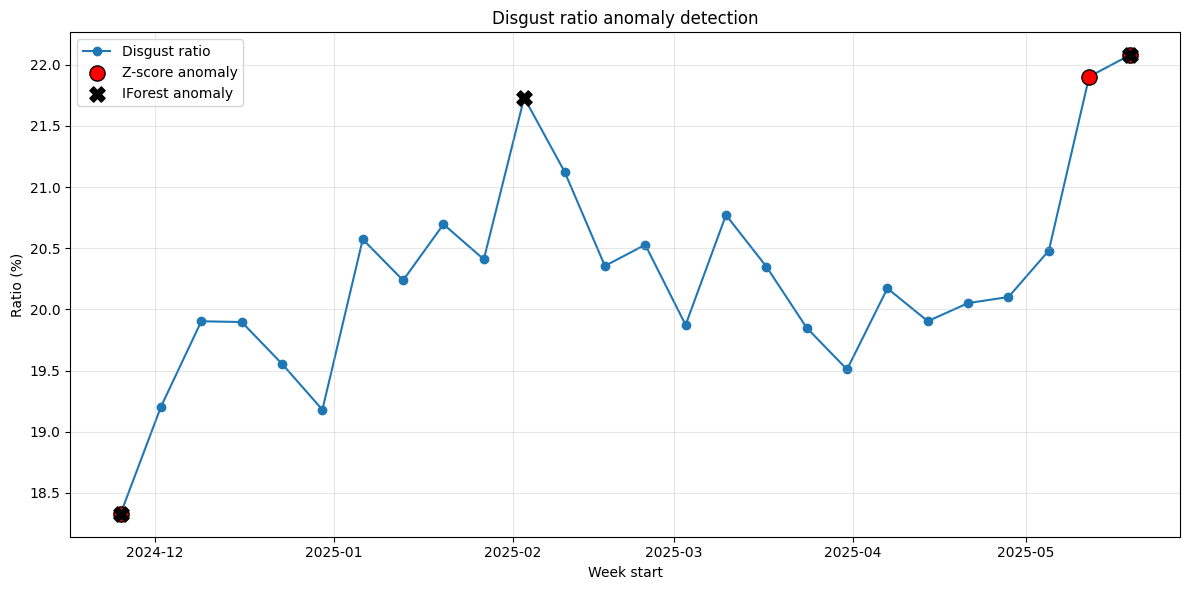

In [77]:
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from scipy.stats import norm

# 주별 집계를 위해 comment_week 컬럼을 datetime 변환
filtered_df["comment_week"] = pd.to_datetime(filtered_df["comment_week"])

# 집계 구조 초기화
week_counts, week_weighted, week_comments = defaultdict(lambda: defaultdict(int)), defaultdict(lambda: defaultdict(float)), defaultdict(int)

# 주별 감정 수와 가중치 집계
for _, row in filtered_df.iterrows():
    week   = row["comment_week"]
    labels = [l for l in row["pred_labels"] if l != "other"]
    if not labels:
        continue
    weight = 1 / len(labels)
    for l in labels:
        week_counts[week][l]   += 1
        week_weighted[week][l] += weight
    week_comments[week] += 1

# 절대 감정 수 데이터프레임 생성
week_df = pd.DataFrame(week_counts).T.fillna(0).astype(int)
week_df.index.name = "week_start"
week_df["total_comments"] = pd.Series(week_comments)

# 최소 건수 필터 적용
week_df = week_df[week_df["total_comments"] >= 50].sort_index()

# 가중치 기반 주별 비율 계산
week_weighted_df = pd.DataFrame(week_weighted).T.fillna(0).reindex(week_df.index, fill_value=0)
week_ratio_df    = week_weighted_df.div(week_df["total_comments"], axis=0) * 100

# 분석할 감정 컬럼 설정 (여러개 선택 가능)
emotion_columns = ["혐오"]
emotion_map     = emotion_map = {
    "분노": "Anger",
    "기대": "Anticipation",
    "기쁨": "Joy",
    "신뢰": "Trust",
    "공포": "Fear",
    "놀람": "Surprise",
    "슬픔": "Sadness",
    "혐오": "Disgust"
}

# 결합 비율 계산
if len(emotion_columns) == 1:
    series = week_ratio_df[emotion_columns[0]]
else:
    series = week_ratio_df[emotion_columns].sum(axis=1)

# Z-score 이상치 탐지 함수 정의
def detect_z_anomalies(s, thr):
    z = (s - s.mean()) / s.std()
    return z[z.abs() > thr].index

# Isolation Forest 이상치 탐지 함수 정의
def detect_iforest_anomalies(df, n_estimators=100, contamination=0.1):
    model = IsolationForest(n_estimators=n_estimators,
                            contamination=contamination,
                            random_state=42)
    preds = model.fit_predict(df)
    return df.index[preds == -1]

# 파라미터 설정
alpha     = 0.05
threshold = norm.ppf(1 - alpha/2)  # 95% 기준 z≈1.96

# 이상치 계산
z_anoms  = detect_z_anomalies(series, threshold)
if_anoms = detect_iforest_anomalies(week_ratio_df[emotion_columns])

# 이상치 날짜 출력
print("Z-score anomalies:", [d.date() for d in z_anoms])
print("IForest anomalies:", [d.date() for d in if_anoms])

# 플롯 그리기
label_en = "+".join([emotion_map[e] for e in emotion_columns]) + " ratio"
plt.figure(figsize=(12, 6))
plt.plot(
    week_ratio_df.index,
    series,
    marker='o', linestyle='-',
    label=label_en,
    zorder=1
)
if len(z_anoms) > 0:
    plt.scatter(
        z_anoms,
        series.loc[z_anoms],
        s=120, color='red', edgecolor='black',
        marker='o', zorder=5,
        label='Z-score anomaly'
    )
if len(if_anoms) > 0:
    plt.scatter(
        if_anoms,
        series.loc[if_anoms],
        s=120, color='black',
        marker='X', zorder=5,
        label='IForest anomaly'
    )

# 범례 및 레이아웃 정리
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left')
plt.title(f'{label_en} anomaly detection')
plt.xlabel('Week start')
plt.ylabel('Ratio (%)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [78]:
for week in sorted(set(z_anoms) | set(if_anoms)):
    # 그 주에 해당하는 날짜들 추출
    days = [d for d in daily_keywords
            if pd.to_datetime(d).to_period("W") == week.to_period("W")]
    # 일별 키워드 합산
    kws = Counter()
    for d in days:
        kws.update(dict(daily_keywords[d]))
    # 출력: Week + Top10 keywords
    print(week.date(), [k for k,_ in kws.most_common(10)])

2024-11-25 ['예산', '민주당', '철회', '대통령실', '이재명', '한동훈', '가상자산', '수출', '예산안', '추경호']
2025-02-03 ['이재명', '대통령', '대왕고래', '헌재', '민주당', '이재용', '탄핵', '곽종근', '홍장원', '계엄']
2025-05-12 ['이재명', '김문수', '대선', '이준석', '윤석열', '손흥민', '탈당', '국힘', '민주당', '경찰']
2025-05-19 ['이재명', '대선', '김문수', '이준석', '단일화', '후반', '레이스', '돌입', '지지율', '격차']


In [79]:
# 이상 주 리스트
weeks = sorted(set(z_anoms) | set(if_anoms))

# 요약 테이블 생성 (Anomaly + Top-10 keywords)
rows = []
for w in weeks:
    # 그 주에 해당하는 날짜들 찾기
    days = [d for d in daily_keywords
            if pd.to_datetime(d).to_period("W") == w.to_period("W")]

    # 일별 키워드 합산
    counter = Counter()
    for d in days:
        counter.update(dict(daily_keywords[d]))

    # 상위 10개 키워드
    top10 = [kw for kw,_ in counter.most_common(10)]

    rows.append({
        "Week Start":       w.date(),
        f"{label_en}":      f"{series.loc[w]:.1f}%",
        "Z-Anomaly":        "✔" if w in z_anoms else "",
        "IF-Anomaly":       "✔" if w in if_anoms else "",
        "Top Keywords":     ", ".join(top10)
    })

summary_df = pd.DataFrame(rows).set_index("Week Start")
display(summary_df)

,Disgust ratio,Z-Anomaly,IF-Anomaly,Top Keywords
Week Start,,,,
2024-11-25,18.3%,✔,✔,"예산, 민주당, 철회, 대통령실, 이재명, 한동훈, 가상자산, 수출, 예산안, 추경호"
2025-02-03,21.7%,,✔,"이재명, 대통령, 대왕고래, 헌재, 민주당, 이재용, 탄핵, 곽종근, 홍장원, 계엄"
2025-05-12,21.9%,✔,,"이재명, 김문수, 대선, 이준석, 윤석열, 손흥민, 탈당, 국힘, 민주당, 경찰"
2025-05-19,22.1%,✔,✔,"이재명, 대선, 김문수, 이준석, 단일화, 후반, 레이스, 돌입, 지지율, 격차"
